# Instructor Task
## Dataset
- [Here](https://s3-us-west-2.amazonaws.com/ga-dat-2015-suneel/datasets/breast-cancer.csv) is the dataset.
- [Here](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names) is a description of the data. Ignore column 0 as it is merely the ID of a patient record.

In [20]:
import pandas as pd
%matplotlib inline  

## 1. Read in the data

In [21]:
breast_cancer = pd.read_csv("breast-cancer.csv",header = None)

cell_features = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
                'concavity', 'concave_points', 'symmetry', 'fractal_dimension']
statistical_attributes = ['mean', 'std_err', 'worst']
new_columns = []

for attribute in statistical_attributes:
    for feature in cell_features:
        new_columns.append("_".join([feature, attribute]))

In [22]:
breast_cancer.columns = ['ID','diagnosis'] + new_columns
breast_cancer.head()

,ID,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 2. Separate the data into feature and target.

In [24]:
def GenerateFeature_and_Target(dataset, feature_variables, target_variable):
    """Given a (dataset) containing the variables listed in (feature_variables)
    and the dependent variable (target_variable), return sub dataframes containing
    feature variables and the target, respectively"""
    return dataset[feature_variables], dataset[target_variable]

#The best features, as noted in accompanying text. No need to overfit
target_var = 'diagnosis'
features = ['area_worst', 'smoothness_worst', 'texture_mean'] 
feature_df, target_df = GenerateFeature_and_Target(breast_cancer, features, target_var)

feature_df.head()

,area_worst,smoothness_worst,texture_mean
0,2019.0,0.1622,10.38
1,1956.0,0.1238,17.77
2,1709.0,0.1444,21.25
3,567.7,0.2098,20.38
4,1575.0,0.1374,14.34


## 3. Create and evaluate using cross_val_score and 5 folds.
- What is the mean accuracy?
- What is the standard deviation of accuracy?

In [35]:
from sklearn import linear_model, cross_validation
classifier = linear_model.LogisticRegression()

In [36]:
num_folds = 5
cross_val_scores = cross_validation.cross_val_score(classifier, feature_df, target_df, cv=num_folds)

In [37]:
print("Mean accuracy:", cross_val_scores.mean())
print("Standard deviation of accuracy:", cross_val_scores.std())

Mean accuracy: 0.914105425164
Standard deviation of accuracy: 0.033241039906


Mean accuracy is 91.4%, with a standard deviation of 3.3%

## 4. Get a classification report to identify type 1, type 2 errors.
- Use train_test_split to run your model once, with a test size of 0.33
- Make predictions on the test set
- Compare the predictions to the answers to determine the classification report

In [40]:
from sklearn import metrics

def Classify_and_Report(classifier, features, targets, test_proportion):
    features_train, features_test, target_train, target_test = cross_validation.train_test_split(
        features, targets, test_size=test_proportion)
    classifier = classifier.fit(features_train, target_train)
    predictions = classifier.predict(features_test)
    report = metrics.classification_report(target_test,predictions)
    print(report)
    return classifier

classifier = Classify_and_Report(classifier, feature_df, target_df, 0.33)

             precision    recall  f1-score   support

          B       0.89      0.98      0.93       120
          M       0.96      0.78      0.86        68

avg / total       0.91      0.91      0.91       188



## 5. Scale the data and see if that improves the score.

In [41]:
from sklearn import preprocessing
scaled_features = preprocessing.scale(feature_df)
classifier = Classify_and_Report(classifier, scaled_features, target_df, 0.33)

             precision    recall  f1-score   support

          B       0.96      0.97      0.97       118
          M       0.96      0.93      0.94        70

avg / total       0.96      0.96      0.96       188



Though results vary, typical accuracy rises from 89-93% to ~94-98% with the inclusion of scaling.  Anecdotally, type-I errors ("false-positive", predicting a malignancy when the tumor is benign) are more common after scaling while type-II errors ("false-negative", predicting a tumor to be benign when it is actually malignant) are more common before scaling.  This could be seen as an additional advantage of scaling - one presumes medical professionals would prefer to err on the side of caution.

## 6. Tune the model using automated parametric grid search via LogisticRegressionCV. Explain your intution behind what is being tuned.

### Q: What should we do to prevent overfitting so our model generalizes well to the test data?

To avoid overfitting:

A.  Reserve a proportion of the data for testing (i.e. data NOT used to calibrate the model itself).  

This is the intuition behind training sets (on which models are calibrated) and testing sets (on which results are validated).  Cross validation is a mechanism to iteratively validate models on a fixed portion of the data, which are excluded from calibration.  For instance, with five folds (see above), we are fitting our model using 80% of the available data and assessing its performance on the remaining 20%, and doing so for each fifth of the data.  Should the model perform well in validation over each fifth, we may feel confident that the solution generalizes.

B.  Avoid inclusion of additional features without substantial domain knowledge suggesting this should be done.  

Minimizing superfluous dimensionality helps ensure that models describe the underlying signal associated with data
rather than noisy, idiosyncratic relationships that are unlikely to exist outside the calibration data.

C.  Utilize a regularization parameter where necessary.

A regularization parameter (what is being tuned in this case), at least in cases of parametric regressions (which 
logistic regression certainly is), prevents any individual coefficient from being assigned too large of a value.  The
intuition here, canonically, is explained by a polynomial of degree 10 being used to fit 10 data points.  It is possible
to choose ten coefficients such that the polynomial passes through all ten points perfectly - of course such a polynomial would
have little validity for any data other than the ten points on which it was fit.  Lowering a regularization parameter, and
thus forcing lower values of coefficients minimizes the potential for this type of overfitting.

In [16]:
log_reg_cv = linear_model.LogisticRegressionCV()
classifier = Classify_and_Report(classifier, scaled_features, target_df, 0.33)
print("The best value of C:", classifier.C)

             precision    recall  f1-score   support

          B       0.97      0.99      0.98       121
          M       0.98      0.94      0.96        67

avg / total       0.97      0.97      0.97       188

The best value of C: 1.0


### Q: What was the best C?

We are unable to improve upon the default regularization parameter, C = 1.0.

## 7. Create Two Plots that describe the data and discuss your results

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

visualization_df = pd.DataFrame({"Diag": target_df})
for i,feature in enumerate(features):
    visualization_df[feature] = feature_df[feature]

benign_df = visualization_df[visualization_df.Diag == "B"]
malignant_df = visualization_df[visualization_df.Diag == "M"]

c:\anaconda3\lib\site-packages\matplotlib\collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


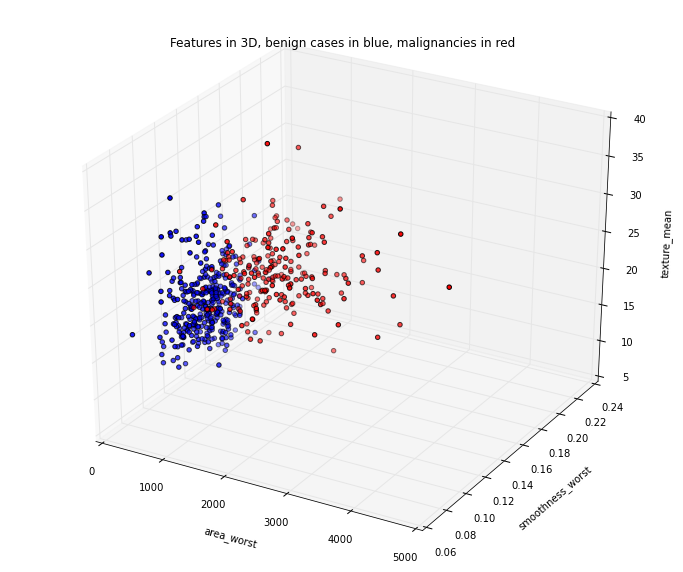

In [18]:
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(benign_df[features[0]], benign_df[features[1]], benign_df[features[2]], c='b', marker='o')
ax.scatter(malignant_df[features[0]], malignant_df[features[1]], malignant_df[features[2]], c='r', marker='o')
ax.set_xlabel(features[0]); ax.set_ylabel(features[1]); ax.set_zlabel(features[2])
plt.xlim(0,5000); plt.ylim(0.06,0.24); ax.set_zlim(5,40)
plt.title("Features in 3D, benign cases in blue, malignancies in red")
plt.show(); plt.close()

In the 3d scatter-plot above, we visualize benign tumors in blue and malignancies in red.  This allows an overview of the two
classifications and the fact that they are likely to be nicely partitioned by a relatively simple model (e.g. a logistic
regression).  We will drill down qualitatively in the subsequent plot.

c:\anaconda3\lib\site-packages\matplotlib\collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


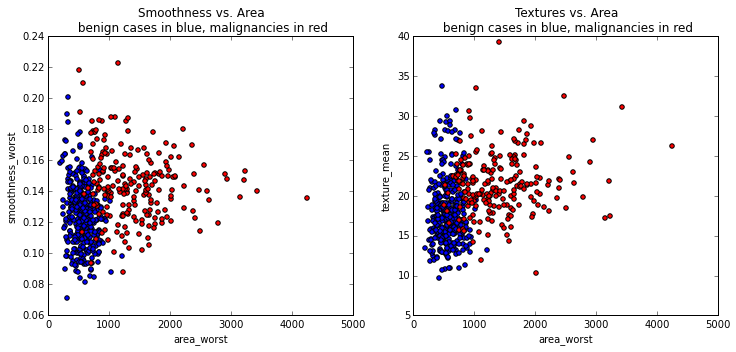

In [19]:
from matplotlib import gridspec
fig = plt.figure(figsize = (12,5))
gs = gridspec.GridSpec(1,2)
ax1 = plt.subplot(gs[0])
ax1.scatter(benign_df[features[0]], benign_df[features[1]], c='b', marker='o')
ax1.scatter(malignant_df[features[0]], malignant_df[features[1]], c='r', marker='o')
ax1.set_xlabel(features[0]); ax1.set_ylabel(features[1])
ax1.set_xlim(0,5000); ax1.set_ylim(0.06,0.24)
plt.title("Smoothness vs. Area \n benign cases in blue, malignancies in red")

ax2 = plt.subplot(gs[1])
ax2.scatter(benign_df[features[0]], benign_df[features[2]], c='b', marker='o')
ax2.scatter(malignant_df[features[0]], malignant_df[features[2]], c='r', marker='o')
ax2.set_xlabel(features[0]); ax2.set_ylabel(features[2])
ax2.set_xlim(0,5000); ax2.set_ylim(5,40)

plt.title("Textures vs. Area \n benign cases in blue, malignancies in red")
plt.show(); plt.close()

In the image above, the left panel plots the worst smoothness values and worst area values, the higher values reflecting 
less uniformly-shaped, and larger cell nuclei respectively, revealing a qualitative relationship.  Independent of smoothness, the presence of 
very large cell nuclei (x-axis, increasing from left-to-right) is likely to indicate malignancy (red).  In fact, virtually every value above 1000 for 'area_worst' 
occurs in a malignant example.  The same pattern emerges on the right panel, comparing the average texture variation to area.  Again, larger nuclei are likely evidence of malignancy.

## 8. Provide a one-sentence summary for a non-technical audience. Then provide a longer paragraph-length technical explanation.

One sentence for a non-technical crowd:
Our model can determine, using only three simple characteristics of cell nuclei, whether or not a tumor is benign or malignant 
with over 95% accuracy.

One paragraph for the technically-inclined:
A logistic regression was implemented, utilizing three features - the area of the largest nuclei, nuclei texture, and nuclei smoothness (variation in nuclei radii, i.e. how misshapen).  Calibration occurred on a randomly-chosen 2/3 of the available data, with the remaining 1/3 withheld for validation. Initial accuracy of roughly 90% was improved by normalizing
input features, yielding accuracy of over 95% in the test sample.  Inspection of scatter plots reveals qualitatively that tumors containing nuclei with extremely large areas are likely to be evidence of malignancy.